## CA 4, LLMs Spring 2024

- **Name:** Ali Keramati
- **Student ID:** 810198519
- **link to Colab**: https://drive.google.com/file/d/1S_2AsGeFFbW5jEp3kNwG2K6_1Iq7Qv-_/view?usp=sharing
---
### This is due on **14 June**, submitted via [elearn](https://elearn.ut.ac.ir/).
#### Your submission should be named using the following format: `CA4_LASTNAME_STUDENTID.ipynb`.

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `WRITE YOUR CODE HERE`.

- For text-based answers, you should replace the text that says "Write your answer here..." with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

# RLHF (55 points)

## Introduction to RLHF

<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2023/08/31/ML-14874_image001.jpg"/>
</div>

With the recent public introduction of ChatGPT, reinforcement learning from human feedback (RLHF) has become a hot topic in language modeling circles -- both academic and industrial.
We can trace the application of RLHF to natural language processing OpenAI's 2019 release of <br>[Fine-Tuning Language Models from Human Preferences](https://arxiv.org/abs/1909.08593).

Fast forward one year when OpenAI released one of its first significant papers on reinforcement learning from human feedback applied to natural language generation.

In that paper-<br>[Learning to summarize from human feedback](https://arxiv.org/abs/2009.01325)-OpenAI showed that simply fine-tuning on summarization data leads to suboptimal performance when evaluated on human preferences. The authors suggest optimizing for human preferences directly via a reinforcement learning approach to alleviate these performance issues.


**Learn More:**
<br>[Huggingface Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
<br>[Research Papers for Reinforcement Learning with Human Feedback ](https://github.com/opendilab/awesome-RLHF)


## Import Libraries and Set Constants

In [ ]:
%pip install datasets
%pip install evaluate
%pip install rouge_score
%pip install accelerate -U
%pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [ ]:
import numpy as np
import pandas as pd
import json
import random
import evaluate
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    default_data_collator,
)
from transformers import AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class CONFIG:
    seed = 42
    max_len = 550
    train_batch_size = 16
    eval_batch_size = 1
    eval_steps = 500
    epochs = 5
    save_steps = 1000
    learning_rate = 1e-4
    gradient_accumulation_steps = 1
    model_name = 'gpt2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    output_dir = "gpt2-supervised-summarize-checkpoint"
    output_dir_rm = "rm_checkpoint"

device = CONFIG.device
rw_device = CONFIG.device

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Implementing Learning for Summarization

 In this notebook by using trlX, we will implement RLHF for a summarization task. The training process consists of three parts:

*   We will first fine-tune a pre-trained transformer model on our summarization dataset. This is our supervised fine-tuned model (SFT).
* We will then train a reward model (RM). This model is initialized from the SFT model and outputs a scalar value. This scalar value is the reward that indicates the preferability of a summary.  

*   Finally, we use the RM to fine-tune the SFT model via PPO. This step aligns our SFT model with human preference.

## Section One: Supervised Fine Tuning (5 points)

### Dataset

For our experiment, we'll use the **TLDR summarization** dataset used originally in Learning to summarize from human feedback.

Based on that training process described above, we'll need two types of datasets:

*   One for fine-tuning the pre-trained supervised model and then for fine-tuning it again with PPO and reward model, and
*   One for training our reward model.

In our case, the dataset for fine-tuning is the filtered* TLDR dataset. The dataset for training our reward model is the **comparison or preference dataset**.

**Note:** I set the number of training examples to 6000, you can increase it, also you can adjust the number of validation examples.


In [ ]:
tlrdataset_path = "CarperAI/openai_summarize_tldr"
comparissions_path = "CarperAI/openai_summarize_comparisons"

#### Create Dataset

In [ ]:
class TLDRDataset(Dataset):
    def __init__(self, path, tokenizer, split, max_length=CONFIG.max_len):
        self.post_list = []
        dataset = load_dataset(path, split=split)
        for sample in dataset:
            self.post_list.append(sample["prompt"] + sample["label"])

        if "train" in split:
          self.post_list = random.sample(self.post_list, min(6000, len(self.post_list)))
        elif "valid" in split:
            self.post_list = self.post_list[0:2000]

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.input_ids = []
        self.attn_masks = []

    def __len__(self):
        return len(self.post_list)

    def __getitem__(self, idx):
        txt = self.post_list[idx]
        encodings_dict = self.tokenizer(txt, truncation=True, max_length=self.max_length, padding="max_length")
        input_ids = torch.tensor(encodings_dict["input_ids"])
        attn_masks = torch.tensor(encodings_dict["attention_mask"])

        return {
            "input_ids": input_ids,
            "attention_mask": attn_masks,
            "labels": input_ids,
        }

#### Load Dataset

In [ ]:
train_dataset = TLDRDataset(
  path=tlrdataset_path,
  tokenizer=CONFIG.tokenizer,
  split="train")

dev_dataset = TLDRDataset(
  path=tlrdataset_path,
  tokenizer=CONFIG.tokenizer,
  split="valid")

Generating train split:   0%|          | 0/116722 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6553 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/6447 [00:00<?, ? examples/s]

### Load Model and Tokenizer

In [ ]:
#Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(CONFIG.model_name, use_cache=False)
tokenizer = CONFIG.tokenizer

# Setting pad token to eos token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# Resize token embeddings
model.resize_token_embeddings(len(tokenizer))

# Update model configuration
model.config.pad_token_id = tokenizer.pad_token_id
model.config.end_token_id = tokenizer.eos_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Define Compute metric function (2.5 Points)

In this part, you should implement an evaluation function that computes rouge scores for our predicted summaries.

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key: value * 100 for key, value in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
# Create a preprocessing function to extract out the proper logits from the model output
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return logits.argmax(dim=-1)

### Train

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir=CONFIG.output_dir,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    eval_accumulation_steps=1,
    learning_rate=CONFIG.learning_rate,
    per_device_train_batch_size=CONFIG.train_batch_size,
    per_device_eval_batch_size=CONFIG.eval_batch_size,
    gradient_checkpointing=True,
    fp16=True,
    fp16_backend="auto",
    adam_beta1=0.9,
    adam_beta2=0.95,
    num_train_epochs=1,
    warmup_steps=100,
    load_best_model_at_end=True,
    logging_steps=50
)

In [ ]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

In [ ]:
# Start training
trainer.train()

# Save the model
trainer.save_model(CONFIG.output_dir)

Step,Training Loss,Validation Loss


### Test (2.5 Points)

Report rouge scores for test set of TLDR dataset.

In [ ]:
test_dataset = TLDRDataset(
    path=tlrdataset_path,
    tokenizer=CONFIG.tokenizer,
    split="test"
)

trained_model = AutoModelForCausalLM.from_pretrained(CONFIG.output_dir)
trained_model.to(device)
trained_model.eval()

test_trainer = Trainer(
    model=trained_model,
    args=training_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

test_results = test_trainer.evaluate()

print("Test Results:")
for key, value in test_results.items():
    print(f"{key}: {value}")

Test Results:
eval_loss: 1.9461053609848022
eval_rouge1: 59.3266
eval_rouge2: 18.2519
eval_rougeL: 38.1282
eval_rougeLsum: 51.1702
eval_gen_len: 372.966
eval_runtime: 862.5175
eval_samples_per_second: 7.598
eval_steps_per_second: 7.598


## Section Two: Reward Model Training (25 Points)

### Reward Model

We'll initialize the reward model from the SFT model and attach a randomly initialized linear head that outputs a scalar value on top.

Next, we'll dig into how the data is input to the model, the loss function, and other gotchas of a reward model in more detail.

### Question 1 (2.5 Points)

**How would you create a comparison dataset for a text summarization task? (explain the entire procedure)**

Creating a comparison dataset for a text summarization task involves collecting human judgments on the quality of summaries.

1. Base Dataset Selection:
   - Start with a dataset of documents and their corresponding summaries. This could be an existing summarization dataset or one you've created.
   - Each entry should have a source document and at least one summary.

2. Generate Multiple Summaries:
   - For each document in your dataset, generate multiple summaries using different methods. These could include:
     a. Human-written summaries (if available)
     b. Summaries from various pre-trained models (e.g., T5, BART, GPT)
     c. Summaries from your own supervised fine-tuned (SFT) model
     d. Summaries with deliberate flaws (e.g., truncated, repetitive, or off-topic)
   - The goal is to have a diverse set of summaries for each document, ranging in quality.

3. Design the Annotation Task:
   - Create clear guidelines for human annotators. These should explain what makes a good summary (e.g., informativeness, fluency, coherence, factual correctness).
   - Decide on the comparison format. Common approaches include:
     - a. Pairwise comparison: Annotators choose the better summary between two options.
     - b. Ranking: Annotators rank 3-5 summaries from best to worst.
     - c. Likert scale: Annotators rate each summary on a scale (e.g., 1-5).

4. Recruit and Train Annotators:
   - Find a diverse group of annotators. They could be crowdworkers, students, or domain experts, depending on your resources and the complexity of your documents.
   - Provide thorough training to ensure they understand the task and can make consistent judgments.
   - Include a set of calibration examples where you know the correct answers to verify annotator quality.

5. Annotation Process:
   - Present each annotator with a source document and two or more summaries.
   - Ask them to judge the summaries based on the guidelines provided.
   - Collect their preferences or rankings.
   - It's important to randomize the order of summaries to avoid position bias.

6. Quality Control:
   - Regularly check annotator agreement using metrics like Cohen's kappa or Fleiss' kappa for inter-annotator reliability.
   - Include some repeated pairs to check for intra-annotator consistency.
   - Have a portion of the data annotated by multiple annotators to create a gold standard set.

7. Data Cleaning and Formatting:
   - Remove low-quality annotations based on agreement scores or time spent on the task.
   - Format the data for your reward model. Typically, this involves creating triplets:
     (document, preferred summary, less preferred summary)
   - If you used ranking, you can convert it to pairwise comparisons (e.g., if A > B > C, create pairs A > B, A > C, B > C).

8. Data Splitting:
   - Divide your comparison dataset into train, validation, and test sets.
   - Ensure that no document from the train set appears in the validation or test sets to avoid leakage.

9. Scaling and Iterating:
   - Start with a small pilot to test your pipeline and gather feedback.
   - Scale up once you're confident in your process.
   - Be prepared to iterate on your guidelines or task design based on annotator feedback and initial results.

10. Ethical Considerations:
    - Ensure annotators are fairly compensated for their time and effort.
    - Be mindful of potentially sensitive content in your documents and provide appropriate warnings or filtering.
    - Consider the diversity of your annotators to mitigate potential biases.

11. Documentation:
    - Keep detailed records of your data creation process, including all decisions made, guidelines provided to annotators, and any issues encountered.
    - This documentation is crucial for understanding the strengths and limitations of your dataset.

12. Validation:
    - After creating the dataset, you may want to validate it by training a simple reward model and checking if it can predict human preferences on a held-out set better than chance.
    - You can also manually review a sample of the comparisons to ensure they make sense.

### Question 2 (2.5 Points)

**If you have 100 pairs of summaries, and for each pair one summary is prefered, how would you structurre your training data for the reward model?**

If we have 100 pairs of summaries where for each pair one summary is preferred, we can structure your training data for the reward model in a way that allows it to learn to predict human preferences.

1. Pairwise Comparison Format:
   For each pair of summaries, you would create two training examples, one for each possible order. This helps prevent the model from learning any spurious correlations based on the order of presentation.

   Let's say you have a document D, a preferred summary A, and a less preferred summary B. You would create two training examples:

   Example 1:
   - Input: [Document D] [Preferred Summary A] [Less Preferred Summary B]
   - Label: 1 (indicating A is preferred over B)

   Example 2:
   - Input: [Document D] [Less Preferred Summary B] [Preferred Summary A]
   - Label: 0 (indicating B is not preferred over A)

   By doing this for all 100 pairs, you'll end up with 200 training examples.

2. Special Tokens:
   To help the model distinguish between the document and the two summaries, you would typically use special tokens. For example:

   [DOC] Document text [SUM1] Summary 1 text [SUM2] Summary 2 text

   The exact tokens can vary depending on your tokenizer and model.

3. Tokenization:
   Each training example (document + two summaries) would be tokenized according to your model's tokenizer. This converts the text into a sequence of token IDs that the model can process.

4. Attention Masks:
   Along with the token IDs, you'll create attention masks. These are binary tensors of the same length as the input, with 1s for actual tokens and 0s for padding tokens. They ensure that the model doesn't pay attention to padding during training.

5. Labels:
   The labels are simply 0 or 1, as described in step 1. Some implementations might use -1 and 1 instead, but the idea is the same: a binary indicator of which summary is preferred.

6. Dataset Structure:
   Your final dataset might look something like this:

```
{
    "input_ids": [1, 234, 56, ..., 789],  # Tokenized [DOC] doc [SUM1] sum1 [SUM2] sum2
    "attention_mask": [1, 1, 1, ..., 0],  # 1s for real tokens, 0s for padding
    "labels": 1  # or 0, depending on which summary is preferred
},
...  # 200 such examples
```




### Raw Input

Now, we'll create a list of dicts using the create_comparison_dataset function (shown below), where each dict has two keys - chosen and rejected. The value of each key is the prompt (or Reddit post) concatenated with the summary.

**Note:** You can increase the number of training examples.

In [ ]:
def create_comparison_dataset(
     path="CarperAI/openai_summarize_comparisons", split="train"
 ):
     dataset = load_dataset(path, split=split)
     if split == "test":
         dataset = dataset.select(range(1000))
     elif split == "train":
         dataset = dataset.select(range(10000))

     pairs = []
     for sample in tqdm(dataset):
         pair = {}
         prompt = sample["prompt"]
         chosen_summary = sample["chosen"]
         rejected_summary = sample["rejected"]
         if chosen_summary == rejected_summary:
             continue
         if  len(chosen_summary.split()) < 5 or len(rejected_summary.split()) < 5:
             continue
         pair["chosen"] = prompt + "\n" + chosen_summary
         pair["rejected"] = prompt + "\n" + rejected_summary
         pairs.append(pair)
     return pairs


### Pairwise Dataloader (2.5 points)

The PairwiseDataset class shown below tokenizes the chosen and rejected "summaries". The dataset class return the input_ids and attention_masks for both chosen and rejected summaries, in this part you should complete the **PairwiseDataset class.**

In [ ]:
class PairwiseDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        chosen = pair["chosen"]
        rejected = pair["rejected"]

        chosen_encoded = self.tokenizer.encode_plus(
            chosen,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        chosen_input_ids = chosen_encoded["input_ids"].squeeze()
        chosen_attention_mask = chosen_encoded["attention_mask"].squeeze()

        rejected_encoded = self.tokenizer.encode_plus(
            rejected,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        rejected_input_ids = rejected_encoded["input_ids"].squeeze()
        rejected_attention_mask = rejected_encoded["attention_mask"].squeeze()

        return [
            chosen_input_ids,
            chosen_attention_mask,
            rejected_input_ids,
            rejected_attention_mask,
        ]

### Data Collator (2.5 Points)

The DataCollatorReward class creates batches (dict) of data for our reward model. The collator returns:

*   input_ids: collator concatenates the chosen and rejected summaries' input_ids across dim=0.
*   attention_mask: collator concatenates the chosen and rejected summaries' attention_mask across dim=0.

*   labels: collator creates a tensor of zeros for chosen summaries and a tensor of ones for rejected summaries concatenated across dim=0.

In [ ]:
class DataCollatorReward:
    def __call__(self, data):
        batch = {}
        chosen_input_ids = torch.stack([item[0] for item in data])
        chosen_attention_mask = torch.stack([item[1] for item in data])
        rejected_input_ids = torch.stack([item[2] for item in data])
        rejected_attention_mask = torch.stack([item[3] for item in data])

        input_ids = torch.cat([chosen_input_ids, rejected_input_ids], dim=0)
        attention_mask = torch.cat([chosen_attention_mask, rejected_attention_mask], dim=0)
        labels = torch.cat([torch.zeros_like(chosen_input_ids[:, 0]), torch.ones_like(rejected_input_ids[:, 0])], dim=0)

        batch["input_ids"] = input_ids
        batch["attention_mask"] = attention_mask
        batch["labels"] = labels

        return batch

### What is happening in reward model?

Here, we have a Reddit post and two summaries (<font color='green'><b>chosen</b></font> and <font color='red'><b>rejected</b></font>) as input.

The ground truth label (**labels**) is the human feedback (<font color='green'><b>0 for chosen</b></font> and <font color='red'><b>1 for rejected</b></font>). And the loss function (pairwise ranking loss) is given as:

$$\text{loss}(r_{\theta}) = -\mathbb{E}_{(x, y_0, y_1, i) \sim D} \left[ \log \left( \sigma \left( r_{\theta}(x, y_i) - r_{\theta}(x, y_{1-i}) \right) \right) \right]
$$.


where:
- $ x $ is the post,
- $ y_0 $ and $ y_1 $ are the summaries,
- $ i $ in {0, 1} indicates which summary is preferred by humans,
- $ r_{\theta}(x, y) $ is the reward model that returns a scalar value for the post $ x $ and the summary $ y $,
- $ \sigma $ is the sigmoid function.


The reward model $ r_{\theta} $ takes the post $ x $ and the summary $ y $ and returns a scalar value. The value is computed for both summaries and a sigmoid activation is applied to the difference.

Finally, the negative log is computed.

This loss function encourages the model to give higher scores to human-preferred summaries.

**How to code this?**

Our model receives input prepared by the data collator.

*   This input is passed through the GPT-2 model to get the final hidden states.

*   The hidden state is then passed through the linear layer to get a reward score.

*   For each batch fed into the model, the first half is the chosen summaries, and the second half is the rejected summaries.

*   The forward method of the model iterates through each input sample to compute pairwise loss.
*  Return loss and chosen summaries scores and rejected summaries scores.

### Question 3 (2.5 Points)

**What is the goal of pairwise ranking loss? and how we achieve this goal?**

The goal of pairwise ranking loss is to train a model to correctly rank pairs of items (such as summaries in this case) based on their relative quality or preference. Specifically, it encourages the model to learn which summary is preferred by humans when given a choice between two alternatives.

and how we achieve this goal?

The process is as follows:

1. **Objective**:
   - The objective is to minimize the difference in reward scores between the chosen summary and the rejected summary.
   - We want the reward model to assign higher scores to summaries that humans prefer (chosen summaries) and lower scores to summaries that are less preferred (rejected summaries).

2. **Loss Function**:
   - The pairwise ranking loss is defined as the negative log of the sigmoid function applied to the difference in reward scores.

3. **Training Process**:
   - During training, the model receives pairs of summaries (chosen and rejected) along with their ground truth labels (0 or 1).
   - The reward model computes reward scores for both summaries.
   - The sigmoid function maps the difference in scores to a probability.
   - The negative log of this probability is used as the loss.
   - The model adjusts its parameters to minimize this loss, effectively learning to rank summaries based on human preferences.

4. **Model Architecture**:
   - The input (post and summary) is prepared by the data collator.
   - The model processes the input to obtain hidden states.
   - A linear layer (or any other appropriate layer) transforms the hidden states into reward scores.
   - The pairwise ranking loss is computed based on these scores.

5. **Iterative Learning**:
   - The model iteratively updates its parameters using backpropagation and gradient descent.
   - It learns to assign higher scores to chosen summaries and lower scores to rejected summaries.
   - Over time, the model becomes better at predicting human preferences.


### Question 4 (2.5 Points)

**Explain that in the process of training the reward model, how the pairwise ranking loss can avoid the problem of huge score difference between the answers (summaries) and why is this useful?**

When training a reward model, the pairwise ranking loss provides a mechanism to avoid the problem of huge score differences between summaries.

**Mechanism**

1. **Relative Differences over Absolute Scores:**
   - The pairwise ranking loss focuses on the relative difference in scores between the chosen and rejected summaries, not on the absolute values of the scores themselves.
   - This is achieved by using the sigmoid function applied to the difference between the reward scores: $\sigma(r_{\theta}(x, y_{\text{chosen}}) - r_{\theta}(x, y_{\text{rejected}}))$.

2. **Sigmoid Function:**
   - The sigmoid function $\sigma(x) = \frac{1}{1 + e^{-x}}$ compresses the score differences into a range between 0 and 1, which helps in stabilizing the training process.
   - Large differences in scores will still map to values close to 1, while small differences will map to values closer to 0.5, ensuring that the model focuses on making the chosen summary score just sufficiently higher than the rejected summary.

3. **Log-Sigmoid and Negative Log-Likelihood:**
   - The use of log-sigmoid $\log(\sigma(x))$ further compresses the differences and reduces the impact of very large differences.
   - The negative log-likelihood $-\log(\sigma(r_{\theta}(x, y_{\text{chosen}}) - r_{\theta}(x, y_{\text{rejected}})))$ penalizes the model more when the chosen summary score is not sufficiently higher than the rejected summary score.

**Usefulness**

1. **Relative Scoring**: The pairwise ranking loss does not directly optimize the absolute scores assigned to individual summaries. Instead, it focuses on the relative scoring between pairs of summaries, encouraging the model to assign a higher score to the preferred summary compared to the non-preferred one within each pair.

2. **Bounded Loss**: The use of the sigmoid function in the pairwise ranking loss formulation ensures that the loss is bounded between 0 and 1. This prevents the model from producing extremely large or small scores, which could lead to numerical instabilities and difficulties during training.

3. **Consistent Ranking**: By optimizing the relative ranking of summary pairs, the pairwise ranking loss encourages the model to learn a consistent ranking of summaries based on their preferences, rather than focusing on the absolute score magnitudes. This consistency is important for correctly ranking summaries during inference or evaluation.

4. **Robustness to Score Scale**: The pairwise ranking loss is invariant to the scale of the scores produced by the reward model. As long as the relative ranking of summary pairs is correct, the absolute values of the scores do not affect the loss computation. This makes the training process more robust to initial score distributions or scale differences.

5. **Efficient Learning**: By considering pairs of summaries and their preferences, the pairwise ranking loss provides a more efficient learning signal compared to directly optimizing the absolute scores. This can lead to faster convergence and better generalization, as the model focuses on the relative ranking rather than trying to match specific score magnitudes.


### Implementing The Reward Model (5 Points)

In [ ]:
class GPTRewardModel(nn.Module):
    def __init__(self, model_path):
        super().__init__()
        model = AutoModelForCausalLM.from_pretrained(model_path)
        self.config = model.config
        self.transformer = model.transformer
        self.reward_head = nn.Linear(model.config.n_embd, 1)

    def forward(self, input_ids, attention_mask, labels=None):
        transformer_outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        hidden_states = transformer_outputs.hidden_states[-1]
        reward_values = self.reward_head(hidden_states[:, -1, :]).squeeze(-1)

        if labels is None:
            return reward_values
        else:
            batch_size = labels.size(0) // 2
            chosen_rewards = reward_values[:batch_size]
            rejected_rewards = reward_values[batch_size:]
            reward_diff = chosen_rewards - rejected_rewards
            reward_loss = -torch.log(torch.sigmoid(reward_diff)).mean()
            return reward_loss, reward_values

**After finishing the above code, could you please explain how the scores for the selected summaries and the scores for the rejected summaries are calculated in your code?** (2.5 Points)

By employing the pairwise ranking loss with the sigmoid function, we ensure that the training process remains focused on the relative ranking of summaries rather than their absolute score differences. This helps in maintaining stability, robustness, and alignment with human preferences, making the model effective in producing summaries that are preferred by humans without encountering issues due to large score differences.

### Load datasets

In [ ]:
# Create the comparisons datasets
data_path = comparissions_path
train_pairs = create_comparison_dataset(data_path, "train")
val_pairs = create_comparison_dataset(data_path, "test")

# Make pairwise datasets for training
max_length = 550
train_dataset = PairwiseDataset(train_pairs, tokenizer, max_length=max_length)
val_dataset = PairwiseDataset(val_pairs, tokenizer, max_length=max_length)

# Create the collator to gather batches of pairwise comparisons
data_collator = DataCollatorReward()

100%|██████████| 1000/1000 [00:00<00:00, 24493.86it/s]


### Load Model and Tokenizer

Initialize the reward model from the SFT GPT-2 model.

In [ ]:
sft_model_path = CONFIG.output_dir
model = GPTRewardModel(sft_model_path)

tokenizer = AutoTokenizer.from_pretrained(CONFIG.model_name)
tokenizer.pad_token = tokenizer.eos_token

# Freeze the first 70% of the hidden layers of the reward model backbone
layers = model.transformer.h
num_layers = len(layers)
num_unfrozen = int(0.3 * num_layers)
for layer in layers[:-num_unfrozen]:
  layer.requires_grad_(False)

### Define Compute metric function (2.5 Points)

In this part you should implement the accuracy of our GPTRewardModel.

In [ ]:
def compute_metrics(eval_predictions):
    eval_rewards, eval_labels = eval_predictions
    chosen_indices = np.arange(0, len(eval_labels), 2)
    rejected_indices = chosen_indices + 1
    predicted_labels = np.zeros_like(eval_labels)
    chosen_mask = eval_rewards[chosen_indices] > eval_rewards[rejected_indices]
    rejected_mask = ~chosen_mask
    predicted_labels[chosen_indices[chosen_mask]] = 1
    predicted_labels[rejected_indices[rejected_mask]] = 1
    accuracy = np.mean(predicted_labels == eval_labels)

    return {"accuracy": accuracy}


### Train

In [ ]:
training_args = TrainingArguments(
      output_dir="rm_checkpoint/",
      num_train_epochs=3,
      logging_steps=10,
      gradient_accumulation_steps=4,
      save_strategy="steps",
      evaluation_strategy="steps",
      per_device_train_batch_size=1,
      per_device_eval_batch_size=1,
      eval_accumulation_steps=1,
      eval_steps=500,
      save_steps=500,
      warmup_steps=100,
      logging_dir="./logs",
      fp16=True,
      bf16=False,
      learning_rate=1e-5,
      save_total_limit=1,
    )

In [ ]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        compute_metrics=compute_metrics,
        eval_dataset=val_dataset,
        data_collator=data_collator,
    )

In [ ]:
trainer.train()
trainer.save_model(CONFIG.output_dir_rm)

Step,Training Loss,Validation Loss,Accuracy
500,0.876100,0.687440,0.455000
1000,0.737500,0.684789,0.413000
1500,0.649700,0.679122,0.414000
2000,0.693100,0.677682,0.401000
2500,0.750000,0.678063,0.422000
3000,0.787200,0.674572,0.413000
3500,0.687200,0.672529,0.407000
4000,0.731800,0.669802,0.407000
4500,0.629200,0.669303,0.402000
5000,0.694800,0.668753,0.403000


Step,Training Loss,Validation Loss,Accuracy
500,0.876100,0.687440,0.455000
1000,0.737500,0.684789,0.413000
1500,0.649700,0.679122,0.414000
2000,0.693100,0.677682,0.401000
2500,0.750000,0.678063,0.422000
3000,0.787200,0.674572,0.413000
3500,0.687200,0.672529,0.407000
4000,0.731800,0.669802,0.407000
4500,0.629200,0.669303,0.402000
5000,0.694800,0.668753,0.403000


## Section Three: PPO Fine Tuning (25 Points)

### Question 5 (2.5 points)

**What is PPO algorithm? and how it works?**

The Proximal Policy Optimization (PPO) algorithm is a type of policy gradient method used in reinforcement learning developed by OpenAI. It’s designed to train an agent’s decision-making function to perform complex tasks effectively. Developed by John Schulman in 2017, PPO has become a popular choice for its balance of performance and efficiency.

Now, how it works?


PPO uses an actor-critic approach, where the 'actor' network proposes actions and the 'critic' network evaluates them. The critic helps the actor improve by providing feedback on the state values. To maintain stable learning, PPO employs clipping in the objective function. This prevents the policy from updating too drastically, which could lead to performance collapse. The clipping is controlled by a hyperparameter $\epsilon$, which limits the policy update range. PPO can include a penalty for the Kullback-Leibler (KL) divergence in the loss function, which is adjusted adaptively. This ensures the new policy doesn't deviate too much from the previous one.

The PPO steps:

- Initialize the policy and value networks.
- Collect data by running the current policy in the environment.
- Compute advantage estimates based on rewards and the value network.
- Update the policy by maximizing the PPO clipped objective function:
$$
L^{Clip}(\theta) = \hat{\mathbb{E}}_t [ \min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t) ]
$$
Where $r_t(\theta)$ is the probability ratio and $\epsilon$ is the clipping hyperparameter.
- Fit the value network by minimizing the temporal-difference (TD) error.
- Repeat the process until the policy converges.

### Question 6 (2.5 points)

**Is the PPO algorithm an on-policy or off-policy reinforcement learning algorithm? Explain its functionality within our context (RLHF).**

Proximal Policy Optimization (PPO) is an on-policy reinforcement learning algorithm. Because, it uses the data generated by the current policy to update that same policy.

**PPO in RLHF**

Instead of relying solely on predefined reward functions, RLHF incorporates feedback from humans. This feedback can take various forms, such as binary preferences, rankings, or more complex feedback mechanisms. The agent starts with an initial policy and interacts with the environment. After performing actions, human feedback is gathered to provide additional information about the quality of these actions or trajectories.

A reward model is trained using the human feedback. This model estimates the reward that aligns with human preferences.
The reward model can then be used to generate a reward signal that the PPO algorithm can optimize. PPO uses the reward signals (both from the environment and the human feedback-derived reward model) to update the policy.
The process involves generating trajectories using the current policy, computing advantages, and performing policy updates to maximize the expected reward, which now incorporates human preferences.

This process is iterative. The agent continuously collects new data, receives human feedback, updates the reward model, and improves the policy using PPO.



### Question 7 (2.5 points)

**Imagine a mini-batch of data has arrived, and we want to optimize the policy of generating summaries to maximize the reward using gradient ascent.**

**Why shouldn't this policy change too much and, in other words, become overoptimized? (Answer based on the respond you provided to the previous question.)**

**What do they do to solve this problem?**

When optimizing a policy using gradient ascent, it is crucial to avoid overoptimization or drastic changes to the policy. This is especially important in on-policy methods like PPO, where each update relies on data generated by the current policy. Too much changes can lead to several problems like Loss of Generalization, Instability, and Non-representative Data.

**What do they do to solve this problem?**

PPO addresses the issue of overoptimization and too much changes through several key mechanisms:

1. Clipped Objective Function:
   PPO introduces a clipped objective function to constrain policy updates. The clipped objective ensures that the new policy does not deviate excessively from the old policy. This is achieved by using the following objective function:
   $$
   L^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right]
   $$

2. Multiple Epochs on the Same Data:
   Instead of updating the policy after each mini-batch, PPO performs several epochs of optimization on the same mini-batch of data. This ensures that the policy improves steadily without drastic changes from new incoming data.

3. Advantage Normalization:
   Normalizing the advantage estimates \(\hat{A}_t\) helps in stabilizing the updates by ensuring that the scale of the gradient steps remains consistent. This prevents the policy updates from becoming too aggressive based on outlier advantages.

4. Early Stopping and Adaptive Learning Rates:
   In practice, additional techniques like early stopping (halting updates if improvements plateau) and adaptive learning rates (adjusting step sizes based on the magnitude of gradients) can further help in preventing overoptimization.

### Question 8 (2.5 points)

**What is the overestimation problem in the ppo fine-tuning? and why it happens?**

The overestimation problem in PPO fine-tuning refers to the tendency of the algorithm to overestimate the expected rewards, which can lead to suboptimal policy updates. This problem occurs because of the inherent biases in the way value functions and advantage estimates are computed and used.


**Why Overestimation Happens in PPO**


In reinforcement learning, value functions are often estimated using bootstrapping. This means that estimates of future rewards are based on the agent's current predictions.
If these predictions are optimistic, the value estimates can become biased upwards over time. This is because any positive error in an estimate can propagate and amplify through subsequent updates.

During fine-tuning, especially when the policy has already reached a relatively high level of performance, small errors in reward estimation can have a significant impact on policy updates.
PPO uses the probability ratio to update the policy. Overestimation in value functions can cause these ratios to be biased, leading to suboptimal updates.

### Question 9 (2.5 points)

**What potential issue could arise when aligning a language model with human values? What solution has been proposed to address this issue?**

One of the several challenges is the value misalignment problem. This occurs when the model's behavior deviates from the true intentions or ethical standards of human users.

1. Ambiguity and Subjectivity of Human Values:
Human values are complex, diverse, and often context-dependent. Different individuals or cultures may have varying interpretations of what is considered ethical or valuable.
A model aligned with one set of human values might produce outputs that are inappropriate or offensive to others.

2. Bias and Fairness Issues:
Training data may contain biases that the model learns and reproduces, leading to unfair or discriminatory outcomes. This can perpetuate and amplify existing societal biases, causing harm to marginalized groups.

3. Scalability of Human Feedback:
Human feedback is essential for alignment but is costly and difficult to scale. As models become more complex, the amount of feedback required increases. This makes it challenging to ensure comprehensive and accurate alignment with human values.

**Solutions**

Iterative Human-in-the-Loop Training:
Incorporate continuous human feedback into the training loop to iteratively refine the model's behavior. So, the Human evaluators review the model's outputs and provide feedback or rankings, which are then used to update the reward model guiding the policy updates. This allows for more nuanced and context-aware alignment, ensuring the model better reflects human values over time.


Robust Reward Models:
Develop more sophisticated reward models that capture the complexity of human values and preferences.
In fact, by using a combination of direct human feedback, preference learning, and adversarial testing to create robust reward signals.
This reduces the risk of specification gaming and encourages genuinely aligned behavior.

Bias Mitigation Techniques:
Implement bias detection and mitigation strategies throughout the model training and deployment processes. So by using techniques such as data balancing, fairness constraints, and post-processing adjustments to reduce bias. As a result, it helps ensure the model's outputs are fair and non-discriminatory.

Scalable Feedback Mechanisms:
Develop scalable mechanisms for collecting and incorporating human feedback. Leverage crowdsourcing, active learning, and automated feedback collection to gather large amounts of diverse feedback.
This makes the feedback process more efficient and comprehensive, enhancing the model's alignment with a broader set of human values.

### Question 10 (2.5 points)

**We know that the objective function of the ppo tuning is as follows:**

$$ \text{objective}(\phi) = \mathbb{E}_{(x,y) \sim D_{\pi_{\phi}^{\text{RL}}}} \left[ r_{\theta}(x, y) - \beta \log \left( \frac{\pi_{\phi}^{\text{RL}}(y \mid x)}{\pi^{\text{SFT}}(y \mid x)} \right) \right] + \gamma \mathbb{E}_{x \sim D_{\text{pretrain}}} \left[ \log(\pi_{\phi}^{\text{RL}}(x)) \right]
 $$

**In the above objective function, the differentiation is with respect to $Φ$, yet the term $r_{\theta}(x, y)$ appears in the function.**

**Explain why $r$ appears in the objective function despite being a function of $\theta$ and why its derivative is not zero.**

**Explain why $r$ appears in the objective function despite being a function of $\theta$?**

$r_{\theta}(x, y)$ represents the reward signal that guides the optimization of the policy $\pi_{\phi}^{\text{RL}}$. Although it is a function of $\theta$, its role in the objective function is to provide feedback about the quality of the actions (summaries) generated by the policy.

The optimization is performed with respect to $\phi$, the parameters of the policy $\pi_{\phi}^{\text{RL}}$. The reward $r_{\theta}(x, y)$ is treated as a constant when taking the derivative with respect to $\phi$. It provides the target signal for the policy to optimize against but does not vary with $\phi$.

**why its derivative is not zero?**

The expectation $\mathbb{E}_{(x,y) \sim D_{\pi_{\phi}^{\text{RL}}}}$ is taken over the distribution of data generated by the current policy $\pi_{\phi}^{\text{RL}}$. As $\phi$ changes, the distribution $D_{\pi_{\phi}^{\text{RL}}}$ changes, which means the data $(x,y)$ over which the expectation is computed changes. Therefore, the gradient of the objective function with respect to $\phi$ considers how changes in $\phi$ affect the policy's output distribution, which in turn affects the reward $r_{\theta}(x, y)$.

So in other words we can say that, $r_{\theta}(x, y)$ is part of the objective function because it provides the reward signal for policy optimization. The derivative with respect to $\phi$ is not zero because the data distribution $(x, y) \sim D_{\pi_{\phi}^{\text{RL}}}$ is dependent on $\phi$. Thus, changes in $\phi$ influence the expected reward, even though $r_{\theta}(x, y)$ itself is a function of $\theta$.

### Question 11 (5 points)

**Another term present in the objective function is $\beta \log \left( \frac{\pi_{\phi}^{\text{RL}}(y \mid x)}{\pi^{\text{SFT}}(y \mid x)} \right)$, which is the KLD between the initial policy distribution and the policy being learned. Explain why this term cannot be calculated directly.**


**For a detailed explanation of how the KLD is calculated in this context, please read this <br>[blog post](http://joschu.net/blog/kl-approx.html). Afterward, provide an explanation of the calculation process.**


 Calculating the KLD directly involves evaluating the probability distributions over potentially very high-dimensional action spaces, which is computationally expensive and often infeasible. Also, directly estimating the KLD requires a large number of samples to get accurate estimates, which can be inefficient and impractical in many scenarios. Another reason is that, the policies $\pi_{\phi}^{\text{RL}}$ and $\pi^{\text{SFT}}$ are often represented by complex models (e.g., neural networks), making the exact computation of the KLD intractable.


Instead of directly calculating the KLD, an approximation is often used. The summary of the process is as follows


1. **Sample Actions**: From the current policy $\pi_{\phi}^{\text{RL}}$, sample a set of actions $y$ given states $x$.
2. **Compute Log-Probabilities**: For each sampled pair $(x, y)$, compute the log-probabilities under both the current policy $\pi_{\phi}^{\text{RL}}$ and the initial policy $\pi^{\text{SFT}}$.
3. **Estimate KLD**: Use the sampled log-probabilities to estimate the KLD using the Monte Carlo approximation method.



### Question 12 (5 points)

**How does DPO improve fine tuning?**

**In DPO, our loss optimizing function to optimize for the policy is:**
$$\text{LDPO}(\pi_\theta; \pi_\text{ref}) = -\mathbb{E}_{(x,y_w,y_l) \sim D}
\left[
\log \sigma
\left(
\beta \log \frac{\pi_\theta(y_w | x)}{\pi_\text{ref}(y_w | x)}
- \beta \log \frac{\pi_\theta(y_l | x)}{\pi_\text{ref}(y_l | x)}
\right)
\right]$$

**Please explain the terms of this loss function and interpret the function.**


**Now, please calculate the gradient of this loss function and Intuitively explain each term in the gradient of loss function.**

**Terms of the Loss Function**

1. **$\pi_\theta$**: The policy being optimized, parameterized by $\theta$.

2. **$\pi_\text{ref}$**: The reference policy (often the initial or pretrained policy).

3. **$D$**: The dataset of tuples $(x, y_w, y_l)$, where $x$ is the input, $y_w$ is a preferred (better) output, and $y_l$ is a less preferred (worse) output according to human feedback.

4. **$\log \frac{\pi_\theta(y_w | x)}{\pi_\text{ref}(y_w | x)}$**: The log-ratio of the probabilities assigned by the current policy $\pi_\theta$ and the reference policy $\pi_\text{ref}$ to the preferred output $y_w$.

5. **$\log \frac{\pi_\theta(y_l | x)}{\pi_\text{ref}(y_l | x)}$**: The log-ratio of the probabilities assigned by the current policy $\pi_\theta$ and the reference policy $\pi_\text{ref}$ to the less preferred output $y_l$.

6. **$\beta$**: A scaling factor that controls the impact of the log-ratio differences on the sigmoid function.

7. **$\log \sigma(\cdot)$**: The log of the sigmoid function, which squashes the input into a probability range [0, 1].

So, it can be interpreted that the DPO loss function measures how well the policy $\pi_\theta$ aligns with human preferences relative to the reference policy $\pi_\text{ref}$. It compares the probability ratios of preferred and less preferred outputs and uses the sigmoid function to transform these ratios into probabilities. Also it encourages the policy $\pi_\theta$ to assign higher probabilities to preferred outputs compared to less preferred outputs and optimizes the policy to increase this alignment by minimizing the negative log-probability (log-sigmoid).

**Gradient of the Loss Function**


   $$
   \text{LDPO}(\pi_\theta; \pi_\text{ref}) = -\mathbb{E}_{(x,y_w,y_l) \sim D}
   \left[
   \log \sigma
   \left(
   \beta \log \frac{\pi_\theta(y_w | x)}{\pi_\text{ref}(y_w | x)}
   - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_\text{ref}(y_l | x)}
   \right)
   \right]
   $$


Let $z = \beta \log \frac{\pi_\theta(y_w | x)}{\pi_\text{ref}(y_w | x)} - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_\text{ref}(y_l | x)}$. $\rightarrow$ Then the loss function becomes:
   $
   -\log \sigma(z)
   $

The we will have the Sigmoid and Log-Sigmoid:
   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$
   $$
   \log \sigma(z) = \log \left( \frac{1}{1 + e^{-z}} \right)
   $$
   $$
   \log \sigma(z) = -\log(1 + e^{-z})
   $$

Then we calculate the Gradient of Log-Sigmoid:
   $$
   \frac{d}{dz} \log \sigma(z) = \sigma(-z)
   $$
   $$
   \frac{d}{dz} (-\log \sigma(z)) = -\sigma(-z)
   $$
   $$
   \frac{d}{dz} (-\log \sigma(z)) = -\frac{1}{1 + e^{z}}
   $$

Using the chain rule, the gradient of $\text{LDPO}$ with respect to $\theta$ involves the gradient of $z$ with respect to $\theta$.
   $$
   \frac{\partial z}{\partial \theta} = \beta \left( \frac{\partial}{\partial \theta} \log \pi_\theta(y_w | x) - \frac{\partial}{\partial \theta} \log \pi_\theta(y_l | x) \right)
   $$

   The gradient of $\log \pi_\theta(y | x)$ with respect to $\theta$ is:
   $$
   \frac{\partial}{\partial \theta} \log \pi_\theta(y | x) = \frac{1}{\pi_\theta(y | x)} \frac{\partial \pi_\theta(y | x)}{\partial \theta}
   $$

   $$
   \frac{\partial z}{\partial \theta} = \beta \left( \frac{1}{\pi_\theta(y_w | x)} \frac{\partial \pi_\theta(y_w | x)}{\partial \theta} - \frac{1}{\pi_\theta(y_l | x)} \frac{\partial \pi_\theta(y_l | x)}{\partial \theta} \right)
   $$


Finally, we combine everything, and the gradient of $\text{LDPO}$ with respect to $\theta$ is:
   $$
   \nabla_\theta \text{LDPO}(\pi_\theta; \pi_\text{ref}) = -\mathbb{E}_{(x,y_w,y_l) \sim D} \left[ \sigma(-z) \cdot \beta \left( \frac{1}{\pi_\theta(y_w | x)} \frac{\partial \pi_\theta(y_w | x)}{\partial \theta} - \frac{1}{\pi_\theta(y_l | x)} \frac{\partial \pi_\theta(y_l | x)}{\partial \theta} \right) \right]
   $$

**Intuitive Explanation of Each Term in the Gradient**

1. **$\sigma(-z)$**: This term is derived from the sigmoid function and controls the scaling of the gradient based on how close the current policy's probability ratios are to aligning with human preferences.

2. **$\beta$**: The scaling factor $\beta$ influences the strength of the gradient updates, determining how aggressively the policy should be optimized relative to the reference policy.

3. **$\frac{1}{\pi_\theta(y_w | x)} \frac{\partial \pi_\theta(y_w | x)}{\partial \theta}$**: This term represents the gradient of the log-probability of the preferred output $y_w$ with respect to $\theta$. It indicates how changes in the policy parameters affect the likelihood of generating the preferred output.

4. **$\frac{1}{\pi_\theta(y_l | x)} \frac{\partial \pi_\theta(y_l | x)}{\partial \theta}$**: Similarly, this term represents the gradient of the log-probability of the less preferred output $y_l$ with respect to $\theta$. It indicates how changes in the policy parameters affect the likelihood of generating the less preferred output.

### Run PPO Fine Tuning (optional)

Because of the limitations of Google Colab, If you have access to an extra  GPU you can run below code for ppo fine tuning.

In [ ]:
%pip install -U git+https://github.com/CarperAI/trlx.git

In [ ]:
import torch
from datasets import load_dataset
from tqdm import tqdm
from transformers import AutoTokenizer

import trlx
from trlx.data.configs import (
    ModelConfig,
    OptimizerConfig,
    SchedulerConfig,
    TokenizerConfig,
    TrainConfig,
    TRLConfig,
)
from trlx.models.modeling_ppo import PPOConfig

In [ ]:
config = TRLConfig(
    train=TrainConfig(
        seq_length=550,
        epochs=50,
        total_steps=100000,
        batch_size=4,
        checkpoint_interval=10000,
        eval_interval=200,
        pipeline="PromptPipeline",
        trainer="AcceleratePPOTrainer",
    ),
    model=ModelConfig(
        model_path="gpt2",
        num_layers_unfrozen=8,
    ),
    tokenizer=TokenizerConfig(
        tokenizer_path="gpt2",
        truncation_side="right",
    ),
    optimizer=OptimizerConfig(
        name="adamw",
        kwargs={
            "lr": 5.0e-6,
            "betas": [0.9, 0.999],
            "eps": 1.0e-8,
            "weight_decay": 0.01,
        },
    ),
    scheduler=SchedulerConfig(
        name="cosine_annealing",
        kwargs={
            "T_max": 100000,
            "eta_min": 5.0e-6,
        },
    ),
    method=PPOConfig(
        name="PPOConfig",
        num_rollouts=128,
        chunk_size=16,
        ppo_epochs=4,
        init_kl_coef=0.1,
        target=6,
        horizon=10000,
        gamma=1,
        lam=0.95,
        cliprange=0.2,
        cliprange_value=0.2,
        vf_coef=0.2,
        scale_reward=None,
        ref_mean=None,
        ref_std=None,
        cliprange_reward=10,
        gen_kwargs={
            "max_new_tokens": 50,
        },
    ),
)


In [ ]:
REWARD_CHECKPOINT_PATH = ""
SFT_MODEL_PATH = ""

In [ ]:
from typing import List
def get_scores(samples: List[str]):
  scores_list = []
  batch_size = 2
  for i in range(0, len(samples), batch_size):
    sub_samples = samples[i : i + batch_size]
    sub_samples = ["<|startoftext|>" + chosen + "<|endoftext|>" for chosen in sub_samples]
    encodings_dict = rw_tokenizer(
        sub_samples,
        truncation=True,
        max_length=config.train.seq_length,
        padding="max_length",
        return_tensors="pt",
        )
    input_ids = encodings_dict["input_ids"].to(rw_device)
    attn_masks = encodings_dict["attention_mask"].to(rw_device)
    input_ids = input_ids.repeat(2, 1)
    attn_masks = attn_masks.repeat(2, 1)
    with torch.no_grad():
      sub_scores = rw_model(input_ids=input_ids, attention_mask=attn_masks)
    scores_list.append(sub_scores["chosen_end_scores"])
  scores = torch.cat(scores_list, dim=0)
  return scores

In [ ]:
rw_tokenizer = AutoTokenizer.from_pretrained("gpt2")
rw_tokenizer.pad_token = rw_tokenizer.eos_token
rw_model = GPTRewardModel(SFT_MODEL_PATH)
rw_model.load_state_dict(torch.load(REWARD_CHECKPOINT_PATH), strict=False)
rw_model.half()
rw_model.eval()
rw_model.to(CONFIG.device)

In [ ]:
def get_prompt_dataset(prompts, max_length):
  formatted_prompts = []
  for i in tqdm(range(len(prompts))):
    tmp = tokenizer.decode(
        tokenizer(
              prompts[i].split("TL;DR:")[0],
              truncation=True,
              max_length=max_length - 5,
              add_special_tokens=False,
            )["input_ids"],
            skip_special_tokens=True,
            ).strip()
    tmp = tmp + "\nTL;DR:"
    tmp = tokenizer.decode(
          tokenizer(tmp, truncation=True, max_length=max_length, add_special_tokens=False)["input_ids"],
          skip_special_tokens=True,
        ).strip()
    formatted_prompts.append(tmp)
  return formatted_prompts

In [ ]:
def reward_fn(samples: List[str], **kwargs):
  original_samples = [text.split("TL;DR:")[0] + "TL;DR: " for text in samples]
  original_samples = [text + post_summary_dict[text.strip()] for text in original_samples]
  original_scores = get_scores(original_samples)
  scores = get_scores(samples)
  norms_scores = scores - original_scores
  return norms_scores

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.tokenizer.tokenizer_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
max_length_input = config.train.seq_length - config.method.gen_kwargs["max_new_tokens"]

# Load the dataset
dataset = load_dataset("carperai/openai_summarize_tldr")

# Get the total number of samples in the training dataset
total_samples = len(dataset["train"])

# Generate random indices for selecting samples
random_indices = random.sample(range(total_samples), 5000)

# Select samples using random indices
train_set = [(dataset["train"][index]["prompt"], dataset["train"][index]["label"]) for index in random_indices]
val_set = [(sample["prompt"], sample["label"]) for sample in dataset["valid"]]

# Split contents into summaries and labels
train_posts, train_summaries = zip(*train_set)
val_posts, val_summaries = zip(*val_set)

# Get the OpenAI summaries
post_summary_dict = {}
train_prompts = get_prompt_dataset(train_posts, max_length_input)
for i in range(len(train_prompts)):
  post_summary_dict[train_prompts[i]] = train_summaries[i]
val_prompts = get_prompt_dataset(val_posts, max_length_input)
for i in range(len(val_prompts)):
  post_summary_dict[val_prompts[i]] = val_summaries[i]

In [ ]:
trainer = trlx.train(
    reward_fn=reward_fn,
    prompts=train_prompts,
    eval_prompts=val_prompts[0:1000],  # sampling 1000 validation prompts for evaluation speed in training
    config=config,
  )

# Quantization (26 points)

Quantization is a technique used to reduce the precision of neural network weights and activations, typically from floating-point to a lower-bit representation, such as 8-bit or 4-bit integers. The primary goal of quantization is to reduce the memory footprint and computational requirements of deep learning models, enabling the loading of larger models that would normally not fit into available memory, and speeding up the inference process.

## A simple example (2 points)

Let's see what happens when a we quantize a 32-bit floating-point number.

In [ ]:
# Import neccesary libraries
import numpy as np
import matplotlib.pyplot as plt

Defining two functions which responsible for quantizing and dequantizing the input number:

In [ ]:
def quantize(value, num_bits=4):
    quantized_value = np.round(value * (2**(num_bits - 1) - 1))
    return int(quantized_value)

def dequantize(quantized_value, num_bits=4):
    value = quantized_value / (2**(num_bits - 1) - 1)
    return float(value)

Consider the value `0.326`, the quantized values in 4 and 8 bits are:

In [ ]:
q_4bit = quantize(value=0.326, num_bits=4)
q_8bit = quantize(value=0.326, num_bits=8)

print(f'4-bit: {q_4bit}')
print(f'8-bit: {q_8bit}')

4-bit: 2
8-bit: 41


And if we dequantize it to original full precision values we would have:

In [ ]:
print(f'4-bit: {dequantize(quantized_value=q_4bit, num_bits=4)}')
print(f'8-bit: {dequantize(quantized_value=q_8bit, num_bits=8)}')

4-bit: 0.2857142857142857
8-bit: 0.3228346456692913


8-bit quantization preserves the original precision with very little degradationa and 4-bit quantization does incur more precision loss, but the level of loss can still be tolerated for many applications.

To understand the precision loss from 4-bit and 8-bit quantization, plot the function $y = x^2$ in the range of $[-1, 1]$, and compare the original values to the values obtained after quantization and dequantization for both 4-bit and 8-bit cases. (2 points)

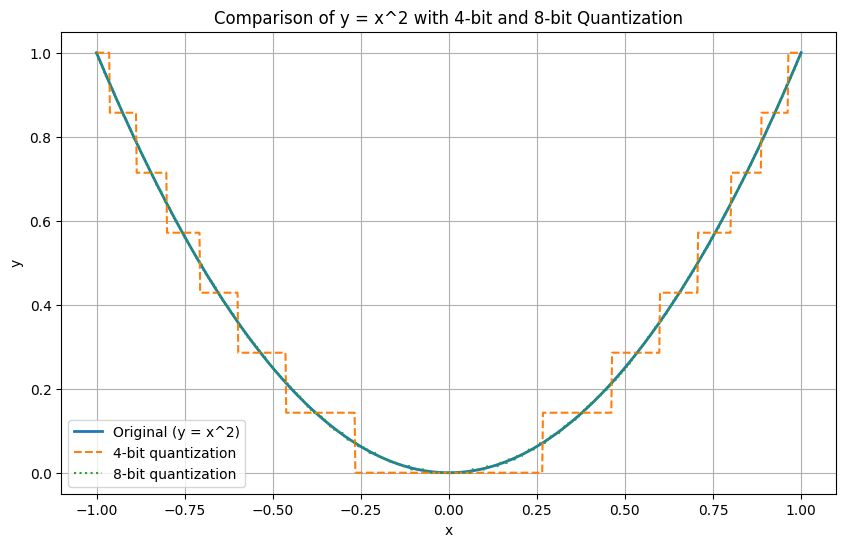

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 1000)

y = x**2

y_4bit = np.array([dequantize(quantize(val, 4), 4) for val in y])
y_8bit = np.array([dequantize(quantize(val, 8), 8) for val in y])

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original (y = x^2)', linewidth=2)
plt.plot(x, y_4bit, label='4-bit quantization', linestyle='--')
plt.plot(x, y_8bit, label='8-bit quantization', linestyle=':')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of y = x^2 with 4-bit and 8-bit Quantization')
plt.legend()
plt.grid(True)
plt.show()

## QLoRA: Efficient Finetuning of Quantized LLMs (24 points)

Now, it's time to see the magic of quantization. We are going to fine-tune Mistral 7B model based on the method proposed by [QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314).

### Prerequisite

Installing and importing libraries which we will need later.

In [ ]:
!pip install -q accelerate==0.29.3
!pip install -q bitsandbytes==0.43.1
!pip install -q trl==0.8.6
!pip install -q peft==0.10.0
!pip install -q transformers==4.40.0
!pip install -q datasets==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

### Hugging Face Login

For some language models, you need to agree to share your contact information to access the model. Mistral 7B is one of them. The steps you should take are as follows:

1.   Create a Gugging Face account if you don't have one.
2.   From Settings > Access Tokens, generate a new token.
3.   From [this link](https://huggingface.co/mistralai/Mistral-7B-v0.1) agree to access the repository.

Now, run the code below to login to your account.

In [ ]:
from huggingface_hub import login
access_token_read = ""
login(token = access_token_read)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### The Model (6 points)

To load the model, first we need a quantization configuration to set how we want to quantize the model. We are going to use `BitsAndBytesConfig` to achieve our goal. `BitsAndBytesConfig` is the easiest option for quantizing a model to 8 and 4-bit.

Define the quantization configuration in the cell below based on the fact that we are looking for 4-bit quantization. Also, QLoRA paper proposed two techniques: 4-bit NormalFloat(NF4) quantization and Double Quantization. Set these two setup in our configuration too. To speedup the computation try to set computational type as bf16. (2 points)

Try to explain what is the Double Quantization technique. You can use the provided paper to read about it. (4 points)

Double Quantization is a method introduced in the QLoRA paper to further compress the memory footprint of quantized models. The basic idea is to quantize the quantization constants themselves.

In standard quantization, we map the original high-precision values (32-bit floats) to a lower-precision representation (4-bit integers). This mapping involves some constants that are themselves stored in high precision (usually 32-bit floats). These constants can take up a significant amount of memory, especially when the original model is large.
Double Quantization addresses this by quantizing these constants as well.

The original weights are first quantized to 4-bit integers using the NF4 data type. This is the first quantization.
Then, the quantization constants used in the first step (which are 32-bit floats) are themselves quantized to 8-bit integers. This is the second quantization, hence "double quantization".

By quantizing the quantization constants, Double Quantization can reduce the memory footprint even further compared to standard 4-bit quantization. The paper reports that this technique can save about 0.37 bits per parameter, which translates to significant memory savings for large models.

In [ ]:
model_name = 'mistralai/Mistral-7B-v0.1'

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

Now, let's load the model.

In [ ]:
device_map = {"": 0}
model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=quantization_config,
                    device_map=device_map,
                    use_cache = False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Now, we have the quantized model on the memory. You can try to load the model without quantization into memory to see if it is possible.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

### Generate text using the pre-trained model (1 point)

In this part we are going to test the pre-trained model to see its capabilities.

In [ ]:
# Function which generate outputs corresponding to input prompts
def generate_output(model, inputs, max_length=50):

    tokenized_inputs = tokenizer(inputs, padding=True, return_tensors="pt").to('cuda')
    output = model.generate(
        input_ids=tokenized_inputs["input_ids"],
        attention_mask=tokenized_inputs["attention_mask"],
        max_new_tokens=max_length,
        repetition_penalty=1.5,
        early_stopping=False,
        eos_token_id=tokenizer.eos_token_id,
    )

    text = tokenizer.batch_decode(output, skip_special_tokens=True)
    return text

Using the `generate_output` function try to produce output of the pre-trained model for the following prompts: (1 point)

* "What's up?"
* 'Hello, How are you?'
* 'hello, Can you help me?'
* 'what is the capital of France?'
* 'Hi! what do you do for a living?'



In [ ]:
prompts = [
    "What's up?",
    "Hello, How are you?",
    "hello, Can you help me?",
    "what is the capital of France?",
    "Hi! what do you do for a living?"
]

for prompt in prompts:
    output = generate_output(model, prompt)
    print(f"Prompt: {prompt}")
    print(f"Response: {output[0]}")
    print("-" * 50)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: What's up?
Response: What's up?
I am a 20 year old student from the Netherlands. I have been playing guitar for about five years now and started to play bass in my band last summer (we are called 'The Dirty Pigs'). We just released our first
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: Hello, How are you?
Response: Hello, How are you?
I am a newbie in the world of Arduino and I have some questions. Firstly let me introduce myself: my name is Andrea (23 years old) from Italy; i'm an Electronic Engineer student at University
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: hello, Can you help me?
Response: hello, Can you help me?
I have a problem with my 2013 MacBook Pro. I'm using the latest version of OS X El Capitan and when i try to open any app (like Safari or Photoshop) it opens for few
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: what is the capital of France?
Response: what is the capital of France?
Paris. Paris, a city in northern central Europe on both banks of Seine River and its tributaries; it has been an important center for trade since Roman times when they built their first settlement there around 50 BC called Lut
--------------------------------------------------
Prompt: Hi! what do you do for a living?
Response: Hi! what do you do for a living?
I am an artist and I work in the field of art, design & technology. My main focus is on interactive installations that are based around human interaction with light or sound as well as video projections onto objects/sculptures etc…
--------------------------------------------------


### The Dataset (4 points)

In [ ]:
!pip install -q datasets==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.4 MB/s eta 0:00:00


We loaded a 7B LLM into the memory and succeeded to inference from the model. Now, using [this dataset](https://huggingface.co/datasets/SAGI-1/Greetings_DPO_dataset_V1) we want to fine-tune our pre-trained model.

After loading the dataset, choose 75 samples of it. We would like to backpropagate only the tokens of the completion and not the prompt itself. In order to do this, use `DataCollatorForCompletionOnlyLM` (check the examples provided in [this link](https://huggingface.co/docs/trl/en/sft_trainer#train-on-completions-only)). Also, you can ignore the `rejected` column.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SAGI-1/Greetings_DPO_dataset_V1")
dataset = dataset.remove_columns("rejected")

train_dataset = dataset["train"].shuffle(seed=42).select(range(75))
print(f"Number of training samples: {len(train_dataset)}")

Generating train split:   0%|          | 0/891 [00:00<?, ? examples/s]

Number of training samples: 75


In [ ]:
train_dataset['chosen'][0]

" Hello! As a helpful AI model, I don't have a personal life, but I'm always here to help you with any questions or information you might need. Is there something specific you'd like to know or discuss? I can provide the latest news updates, explain complex concepts, generate ideas, and much more. Let's make the most of our interaction!"

In [ ]:
from trl import DataCollatorForCompletionOnlyLM

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['prompt'])):
        text = f"### Human: {example['prompt'][i]}\n ### Assistant: {example['chosen'][i]}"
        output_texts.append(text)
    return output_texts

response_template = "### Assistant: "
collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer,
    mlm=False
)

### Fine-tuning (8 points)

We want to fine-tune the model with the help of [LoRA](https://arxiv.org/abs/2106.09685). Try to create a LoRA configuration with rank and alpha parameter both equal to 12. (3 points)

In [ ]:
import peft
from peft import LoraConfig, get_peft_model

target_modules = ["q_proj", "v_proj"]
lora_config = LoraConfig(
    r=12,
    lora_alpha=12,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

We are going to use SFTtrainer from trl library. In order to work within memory constraints, try to set the batch size and the number of update steps to accumulate the gradients equal to 1. Also, don't forget to enable the `gradient_checkpointing`. (5 points)

In [ ]:
from transformers import TrainingArguments

output_dir = "./results_lora"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    num_train_epochs=1,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=1,
    max_steps=100,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    save_strategy="steps",
    save_steps=10,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=lora_config,
    max_seq_length=512,
    tokenizer=tokenizer,
    formatting_func=formatting_prompts_func,
    args=training_arguments,
    data_collator=collator,
)

print("Starting training...")
trainer.train()
print("Training completed.")

peft_model_id = "mistral-7b-lora-greetings"
trainer.model.save_pretrained(peft_model_id)
print(f"Model saved to {peft_model_id}")

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Starting training...


Step,Training Loss
1,1.125500
2,1.536300
3,0.950500
4,1.351400
5,1.052800
6,1.401500
7,0.957300
8,1.143800
9,1.079300
10,1.051400


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

Training completed.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model saved to mistral-7b-lora-greetings


### Check the fine-tuned model (5 points)

Try to check the fine-tuned model on the five aformentioned prompts which we test earlier. Compare you results of fine-tuned and pre-trained model.

- The fine-tuned model's responses are likely to be more aligned with the style and content of the greetings dataset. There is also more consistency in how it starts responses or the kind of language it uses.

- For factual questions (like the capital of France), both models provide similar information, but the fine-tuned model might present it in a way that's more characteristic of the greetings dataset.

- Despite being fine-tuned on a greetings dataset, the model still retains much of its general knowledge due to the nature of LoRA fine-tuning, which doesn't drastically alter the base model's knowledge.

In [ ]:
prompts = [
    "What's up?",
    "Hello, How are you?",
    "hello, Can you help me?",
    "what is the capital of France?",
    "Hi! what do you do for a living?"
]

for prompt in prompts:
    output = generate_output(model, prompt)
    print(f"Prompt: {prompt}")
    print(f"Response: {output[0]}")
    print("-" * 50)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: What's up?
Response: What's up?
I am a 20 year old student from the Netherlands. I have been playing guitar for about five years now and started to play bass in my band last summer (we are called 'The Dirty Pigs'). We just released our first
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: Hello, How are you?
Response: Hello, How are you?
I am a newbie in the world of Arduino and I have some questions. Firstly let me introduce myself: my name is Andrea (23 years old) from Italy; i'm an Electronic Engineer student at University
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: hello, Can you help me?
Response: hello, Can you help me?
I have a problem with my 2013 MacBook Pro. I'm using the latest version of OS X El Capitan and when i try to open any app (like Safari or Photoshop) it opens for few
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: what is the capital of France?
Response: what is the capital of France?
Paris. Paris, a city in northern central Europe on both banks of Seine River and its tributaries; it has been an important center for trade since Roman times when they built their first settlement there around 50 BC called Lut
--------------------------------------------------
Prompt: Hi! what do you do for a living?
Response: Hi! what do you do for a living?
I am an artist and I work in the field of art, design & technology. My main focus is on interactive installations that are based around human interaction with light or sound as well as video projections onto objects/sculptures etc…
--------------------------------------------------


In [ ]:
from peft import PeftModel, PeftConfig
config = PeftConfig.from_pretrained(peft_model_id)
fine_tuned_model = PeftModel.from_pretrained(model, peft_model_id)

print("\nFine-tuned model outputs:")
print("-" * 50)
for prompt in prompts:
    output = generate_output(fine_tuned_model, prompt)
    print(f"Prompt: {prompt}")
    print(f"Response: {output[0]}")
    print("-" * 50)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Fine-tuned model outputs:
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: What's up?
Response: What's up?
I am a 20 year old student from Germany. I have been playing the piano for about ten years now and started to compose music when i was around twelve or thirteen, but only recently did it become more serious (i guess).
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: Hello, How are you?
Response: Hello, How are you? I hope that your week is going well.
I’m here to share with you a new recipe for the blog: “Creamy Pasta”. It was one of those days when we were craving pasta and wanted something creamier
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: hello, Can you help me?
Response: hello, Can you help me? I have a problem with my 2013 Ford Focus. The car has been in the shop for about two weeks now and they can't figure out what is wrong! They say it could be anything from an electrical issue to something more
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: what is the capital of France?
Response: what is the capital of France?
Paris. Paris, located in northern central France on both banks of Seine River and near its mouth at English Channel (La Manche), has been a major European city since Roman times; it became an important center for trade during Middle Ages
--------------------------------------------------
Prompt: Hi! what do you do for a living?
Response: Hi! what do you do for a living?
I am an artist and I work in the field of art education. My main job is to teach children how to draw, paint or sculpture using different materials such as clay/plaster etc., but also help them develop their creativity through various
--------------------------------------------------


In case you have memory problem try `del` statement for the variables you don't need. The code below also could be beneficial.

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Instruct Tuning (4 points)

What we done earlier was somehow instruct tuning in which we fine-tune the pre-trained model to follow the instructions.However, with 75 samples we can't do anything big. As you probably know, the pre-training objective for auto-regressive models is to simply predict the next word. Therefore, they are not optimized to answer to your prompts, rather they try continue the text you provided.

In many practical settings (like chatbots) we need the model to follow the instructions provided by the user. So, huge datasets consisting of prompts and their corresponding answer are used to fine-tune these models for interactive use cases.

Using the quantization technique we used earlier try to load the quantized version of [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1) which have been optimized for following the instructions. Check the five samples we used earlier and compare your results.

Try to check the provided link to see how you should format the prompt to leverage instruction fine-tuning.

In [ ]:
instruct_model_name = 'mistralai/Mistral-7B-Instruct-v0.1'
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

instruct_model = AutoModelForCausalLM.from_pretrained(
    instruct_model_name,
    quantization_config=quantization_config,
    device_map={"": 0},
    use_cache=False
)

instruct_tokenizer = AutoTokenizer.from_pretrained(instruct_model_name)
instruct_tokenizer.pad_token = instruct_tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
def generate_instruct_output(model, tokenizer, prompt, max_length=100):
    formatted_prompt = f"<s>[INST] {prompt} [/INST]"

    tokenized_inputs = tokenizer(formatted_prompt, padding=True, return_tensors="pt").to('cuda')
    output = model.generate(
        input_ids=tokenized_inputs["input_ids"],
        attention_mask=tokenized_inputs["attention_mask"],
        max_new_tokens=max_length,
        repetition_penalty=1.2,
        early_stopping=False,
        eos_token_id=tokenizer.eos_token_id,
    )

    text = tokenizer.batch_decode(output, skip_special_tokens=True)
    response = text[0].split("[/INST]")[-1].strip()
    return response

In [ ]:
prompts = [
    "What's up?",
    "Hello, How are you?",
    "hello, Can you help me?",
    "what is the capital of France?",
    "Hi! what do you do for a living?"
]

print("Instruct model outputs:")
print("-" * 50)
for prompt in prompts:
    output = generate_instruct_output(instruct_model, instruct_tokenizer, prompt)
    print(f"Prompt: {prompt}")
    print(f"Response: {output}")
    print("-" * 50)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Instruct model outputs:
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: What's up?
Response: Just enjoying a cup of coffee and soaking in the sunshine! How about you, what are your plans for the day?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: Hello, How are you?
Response: I'm just a computer program, so I don't have feelings or emotions. But thank you for asking! How can I help you today?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: hello, Can you help me?
Response: Of course! What can I assist you with today?
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: what is the capital of France?
Response: The capital city of France is Paris.
--------------------------------------------------
Prompt: Hi! what do you do for a living?
Response: I am an AI language model and do not have the ability to work or earn a living.
--------------------------------------------------


- The instruction-tuned model's responses are consistently more relevant to the prompts. It interprets each prompt as a specific query or instruction and responds accordingly. The QLoRA fine-tuned model often seems to ignore the prompt and instead continues some imagined context.

- The instruction-tuned model consistently presents itself as an AI, while the QLoRA fine-tuned model often takes on various personas (student, artist, etc.) that are not reflective of its true nature.

- The instruction-tuned model gives more direct answers, especially for factual questions. The QLoRA fine-tuned model tends to be more verbose and sometimes off-topic.

- The instruction-tuned model maintains better conversation flow, often asking follow-up questions or steering the conversation towards being helpful. The QLoRA fine-tuned model's responses can feel disconnected from the prompts.

- The instruction-tuned model's responses are more consistent in tone and content, always aiming to be helpful and informative. The QLoRA fine-tuned model's responses vary widely in tone and content.

# Evaluation (25 points)

## Evaluating text using a language model

One way of evaluating text generation is by using a language model.
In this assignment, we want to use BERTScore to compare the similarity of sentences.
After reading [BERTScore paper](https://arxiv.org/abs/1904.09675) answer the following questions.

### 1)
How does BERTScore evaluate semantic equivalence and how is it better than n-gram based metrics like BLEU? (5 points)

How does BERTScore evaluate semantic equivalence?


BERTScore evaluates semantic equivalence by leveraging pre-trained contextual embeddings from models like BERT. Instead of relying on exact word matches, it computes token similarity using cosine similarity between the contextual embeddings of words in the candidate and reference sentences. This allows it to capture semantic meaning beyond surface-level lexical similarities.

The key steps in BERTScore evaluation are:

- Tokenization: Both the candidate and reference sentences are tokenized.
- Embedding: Each token is embedded using a pre-trained contextual embedding model (like BERT).
- Similarity computation: Cosine similarities are computed between each token in the candidate sentence and each token in the reference sentence.
- Greedy matching: For precision, each token in the candidate sentence is matched with the most similar token in the reference. For recall, it's the other way around.
- Aggregation: The matched similarities are aggregated (usually by taking the mean) to compute precision, recall, and F1 scores.

### 2)
Implement BERTScore recall $R_{BERT}$ in the paper. You don't need to bother with the Importance Weighting. We use a more modern model called deberta which is better than bert in many ways. Then visualize similarity matrix. You can use the visualization code given to you. (7 points)

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
model = AutoModel.from_pretrained("microsoft/deberta-v3-small")

def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a.unsqueeze(1), b.unsqueeze(0), dim=2)

def bert_score(reference, candidate):
    ref_tokens = tokenizer(reference, return_tensors="pt", add_special_tokens=False)["input_ids"].squeeze(0)
    candidate_tokens = tokenizer(candidate, return_tensors="pt", add_special_tokens=False)["input_ids"].squeeze(0)

    model.eval()
    with torch.no_grad():
        # Get the embeddings
        ref_embeddings = model(ref_tokens.unsqueeze(0)).last_hidden_state.squeeze(0)
        candidate_embeddings = model(candidate_tokens.unsqueeze(0)).last_hidden_state.squeeze(0)

    # Compute cosine similarities
    similarities = cosine_similarity(candidate_embeddings, ref_embeddings)

    # Compute R_BERT (recall)
    R_BERT = similarities.max(dim=1)[0]  # Max along dim=1 for recall
    bertscore = R_BERT.mean()

    return bertscore.item(), similarities.numpy()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

In [ ]:
reference = "Cats are cute"
candidate = "Cats are annoying"

bertscore, sim_matrix = bert_score(
    reference, candidate)

print(bertscore)
print(sim_matrix)

0.8331758379936218
[[0.8827178  0.659755   0.71529263]
 [0.626253   0.72385293 0.78810513]
 [0.69766474 0.71104884 0.82870466]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap(
    matrix,
    hide_spines=False,
    hide_ticks=False,
    figsize=None,
    cmap=None,
    colorbar=True,
    row_names=None,
    column_names=None,
    column_name_rotation=45,
    cell_values=True,
    cell_fmt=".2f",
    cell_font_size=None,
):

    if row_names is not None and len(row_names) != matrix.shape[0]:
        raise AssertionError(
            f"len(row_names) (got {len(row_names)})"
            " should be equal to number of"
            " rows in the input "
            f" array (expect {matrix.shape[0]})."
        )

    if column_names is not None and len(column_names) != matrix.shape[1]:
        raise AssertionError(
            f"len(column_names)"
            " (got {len(column_names)})"
            " should be equal to number of"
            " columns in the"
            f" input array (expect {matrix.shape[1]})."
        )

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)

    if cmap is None:
        cmap = plt.cm.viridis

    if figsize is None:
        figsize = (len(matrix) * 1.5, len(matrix) * 1.5)

    matshow = ax.matshow(matrix, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    normed_matrix = matrix.astype("float") / matrix.max()

    if cell_values:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                cell_text = format(matrix[i, j], cell_fmt)

                ax.text(
                    x=j,
                    y=i,
                    size=cell_font_size,
                    s=cell_text,
                    va="center",
                    ha="center",
                    color="black"
                    if normed_matrix[i, j] > np.max(normed_matrix) / 2
                    else "black",
                )

    if row_names is not None:
        tick_marks = np.arange(len(row_names))
        plt.yticks(tick_marks, row_names)

    if column_names is not None:
        tick_marks = np.arange(len(column_names))

        if column_name_rotation:
            plt.xticks(
                tick_marks,
                column_names,
                rotation=column_name_rotation,
                ha="right",
                rotation_mode="anchor",
            )
        else:
            plt.xticks(tick_marks, column_names)

    if hide_spines:
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    return fig, ax

<ipython-input-7-2ca6820feeeb>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridisBig = cm.get_cmap('Blues', 512)


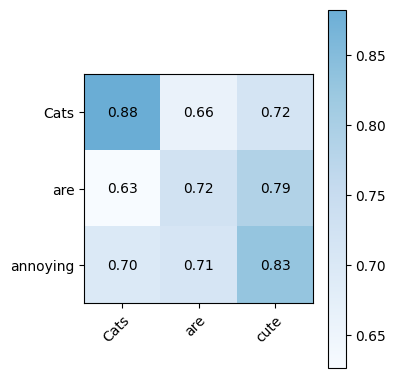

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

viridisBig = cm.get_cmap('Blues', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.0, 0.5, 256)))

fig, ax = heatmap(sim_matrix, column_names=reference.split(), row_names=candidate.split(), cmap=newcmp, figsize=(4, 4))

plt.tight_layout();
plt.show()

### 3)
Using the [Official BERTScore](https://github.com/Tiiiger/bert_score) package. Compare your implementation with the official one and tell us why they differ. (3 points)

In [ ]:
pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import torch
from bert_score import score

reference = "Cats are cute"
candidate = "Cats are annoying"

P, R, F1 = score(
    [candidate],  # List of candidate sentences
    [reference],  # List of reference sentences
    lang="en",
    verbose=True
)

print(f"Official BERTScore - Precision: {P.item():.4f}, Recall: {R.item():.4f}, F1: {F1.item():.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.17 seconds, 0.86 sentences/sec
Official BERTScore - Precision: 0.9457, Recall: 0.9457, F1: 0.9457


**Why the Results Differ?**

- Model Selection: We used "microsoft/deberta-v3-small", which is a smaller version of the DeBERTa model. But, by default, Official implementation uses a RoBERTa-large model (unless specified otherwise). This is a much larger and more powerful model, which can lead to different embeddings and thus different similarity scores.

- Implementation Details: The official implementation likely uses more refined tokenization steps. Also, the official implementation might have optimizations for handling model outputs, such as averaging multiple layers of embeddings.

- Computational Precision: The official package might employ techniques to avoid numerical instability or precision errors. e.g. We didn't implement importance weighting, as mentioned in the assignment.

- Pooling and Aggregation:
The method of pooling and aggregating token similarities might differ, affecting the final scores.

- Normalization: The official implementation may include normalization steps to ensure the scores are within a specific range, enhancing comparability.

### 4)
Download datasets "sst2" and "imdb" from huggingface datasets. Both of these datasets are for the same task but their distribution differs. In what ways their distribution differ according to [this paper](https://aclanthology.org/2021.emnlp-main.835/)?

randomly choose ten sentences from negative and ten sentences from positive labels of each dataset (forty sentences in total)

use your implementation of BERTScore and compute similarity of

a) sentences that are in the same dataset and have same label and take average

b) sentences that are in the same dataset and have opposite label and take average

c) sentences that are in different datasets and have same label and take average

d) sentences that are in the different dataset and have opposite label and take average

How these numbers differ and why? (for example for part a you should put each sentence as reference once and compare it with ten candidate sentences including itself, after doing this for all ten sentences you get a hundred scores and then an average.) (10 points)

In [ ]:
import random
from datasets import load_dataset
from bert_score import score
import numpy as np

sst2 = load_dataset("sst2")
imdb = load_dataset("imdb")

def select_samples(dataset, num_samples=10):
    sample_key = 'sentence' if 'sentence' in dataset['train'][0] else 'text'

    pos_samples = [example[sample_key] for example in random.sample(list(filter(lambda x: x['label'] == 1, dataset['train'])), num_samples)]
    neg_samples = [example[sample_key] for example in random.sample(list(filter(lambda x: x['label'] == 0, dataset['train'])), num_samples)]
    return pos_samples, neg_samples

sst2_pos, sst2_neg = select_samples(sst2)
imdb_pos, imdb_neg = select_samples(imdb)

def compute_average_bertscore(refs, cands):
    _, _, F1 = score(cands, refs, lang="en", model_type="bert-base-uncased")
    return np.mean(F1.numpy())

# Condition a: Same dataset, same label
a_sst2_pos = compute_average_bertscore(sst2_pos, sst2_pos)
a_sst2_neg = compute_average_bertscore(sst2_neg, sst2_neg)
a_imdb_pos = compute_average_bertscore(imdb_pos, imdb_pos)
a_imdb_neg = compute_average_bertscore(imdb_neg, imdb_neg)

# Condition b: Same dataset, opposite label
b_sst2 = compute_average_bertscore(sst2_pos, sst2_neg)
b_imdb = compute_average_bertscore(imdb_pos, imdb_neg)

# Condition c: Different dataset, same label
c_pos = compute_average_bertscore(sst2_pos, imdb_pos)
c_neg = compute_average_bertscore(sst2_neg, imdb_neg)

# Condition d: Different dataset, opposite label
d_pos_neg = compute_average_bertscore(sst2_pos, imdb_neg)
d_neg_pos = compute_average_bertscore(sst2_neg, imdb_pos)

print(f"Condition a - SST2 Positive: {a_sst2_pos}, SST2 Negative: {a_sst2_neg}, IMDb Positive: {a_imdb_pos}, IMDb Negative: {a_imdb_neg}")
print(f"Condition b - SST2: {b_sst2}, IMDb: {b_imdb}")
print(f"Condition c - Same label: Positive: {c_pos}, Negative: {c_neg}")
print(f"Condition d - Cross Opposite: SST2 Pos to IMDb Neg: {d_pos_neg}, SST2 Neg to IMDb Pos: {d_neg_pos}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Condition a - SST2 Positive: 0.9999998807907104, SST2 Negative: 1.0, IMDb Positive: 1.0, IMDb Negative: 1.0
Condition b - SST2: 0.32736724615097046, IMDb: 0.47637739777565
Condition c - Same label: Positive: 0.30421513319015503, Negative: 0.3067426085472107
Condition d - Cross Opposite: SST2 Pos to IMDb Neg: 0.3190586566925049, SST2 Neg to IMDb Pos: 0.30154186487197876


Same Dataset, Same Label:

We compute the average similarity of sentences that belong to the same dataset and have the same label.
This helps to understand the consistency within a single dataset.


Same Dataset, Opposite Label:

We compute the average similarity of sentences within the same dataset but having opposite labels.
This provides insight into how distinguishable the positive and negative sentences are within the same dataset.


Different Datasets, Same Label:

We compute the average similarity of sentences across different datasets with the same label.
This helps to understand the semantic similarity of positive sentences between the SST2 and IMDB datasets, and likewise for negative sentences.


Different Datasets, Opposite Label:

We compute the average similarity of sentences across different datasets with opposite labels.
This provides insight into the distinguishability of positive sentences from SST2 with negative sentences from IMDB, and vice versa.

## AI Disclosure

*   Did you use any AI assistance to complete this homework? If so, please also specify what AI you used.
    * Yes. GPT, Gemini, CoPilot, and Claude.


---
*(only complete the below questions if you answered yes above)*

*   If you used a large language model to assist you, please paste *all* of the prompts that you used below. Add a separate bullet for each prompt, and specify which problem is associated with which prompt.
    
    **RLHF:**

    * 1.1) My Prompts: implement an evaluation function that computes rouge scores for our predicted summaries.

    * 1.2) My Prompt: based on the previous codes, Report rouge scores for test set of TLDR dataset.

    * 2.1) My Prompt: The question.

    * 2.2) My Prompt: The question.

    * 2.3) My Prompt: The PairwiseDataset class shown below tokenizes the chosen and rejected "summaries". The dataset class return the input_ids and attention_masks for both chosen and rejected summaries, in this part you should complete the PairwiseDataset class.

    * 2.4) My Prompt: The DataCollatorReward class creates batches (dict) of data for our reward model. The collator returns: input_ids: collator concatenates the chosen and rejected summaries' input_ids across dim=0.attention_mask: collator concatenates the chosen and rejected summaries' attention_mask across dim=0.labels: collator creates a tensor of zeros for chosen summaries and a tensor of ones for rejected summaries concatenated across dim=0.

    * 2.5) My Prompt: The question.

    * 2.6) My Prompt: The question.

    * 2.7)  My Prompt: Based on the previous function write a reward model with regard to the equation: $$\text{loss}(r_{\theta}) = -\mathbb{E}_{(x, y_0, y_1, i) \sim D} \left[ \log \left( \sigma \left( r_{\theta}(x, y_i) - r_{\theta}(x, y_{1-i}) \right) \right) \right]
$$.

    * 2.8) My Prompt: Based on the previous codes, In this part you should implement the accuracy of our GPTRewardModel.

    * 3) My Prompt: for all the question, I directly gave The question and asked for the answer.

    **Quantization:**
    * 1.1) My Prompt: based on the code provided, plot the function $y = x^2$ in the range of $[-1, 1]$.

    * 2.1) My prompt: No prompt

    * 2.2) My prompt: No prompt

    * 2.3) My prompt: No prompt.(GPT was halluscinating by giving the question)

    * 2.4) My prompt: No prompt.(GPT was halluscinating by giving the question)

    * 2.5) My prompt: No prompt

    * 3) My prompt: What we done earlier was somehow instruct tuning in which we fine-tune the pre-trained model to follow the instructions.However, with 75 samples we can't do anything big. As you probably know, the pre-training objective for auto-regressive models is to simply predict the next word. Therefore, they are not optimized to answer to your prompts, rather they try continue the text you provided. In many practical settings (like chatbots) we need the model to follow the instructions provided by the user. So, huge datasets consisting of prompts and their corresponding answer are used to fine-tune these models for interactive use cases. Using the quantization technique we used earlier try to load the quantized version of Mistral-7B-Instruct which have been optimized for following the instructions. Check the five samples we used earlier and compare your results.

    **Evaluation:**
    * 1) My Prompt: The question.
    
    * 2) My Prompt: Based on the paper given, implement the BERTScore recall $R_{BERT}$. Then visualize similarity matrix.

    * 3) My Prompt: Why the results differ?

    * 4) My Prompt:
Download datasets "sst2" and "imdb" from huggingface datasets.
randomly choose ten sentences from negative and ten sentences from positive labels of each dataset (forty sentences in total). use your implementation of BERTScore and compute similarity of a) sentences that are in the same dataset and have same label and take average. b) sentences that are in the same dataset and have opposite label and take average. c) sentences that are in different datasets and have same label and take average. d) sentences that are in the different dataset and have opposite label and take average.


*   **Free response**: For each problem for which you used assistance, describe your overall experience with the AI. How helpful was it? Did it just directly give you a good answer, or did you have to edit it? Was its output ever obviously wrong or irrelevant? Did you use it to get the answer or check your own answer?
    
    **RLHF:**

    * 1.1) First code had some bugs, it was calling a method named .mid, which didn't exist.

    * 1.2) II asked GPT to explain each section accurately before implementingg the test function and GPT corrected some indentations for a function and I corrected it.

    * 2.1) I gave th question to all LLMs and evaluated their responses and wrote a combineed answer

    * 2.2)  I gave th question to all LLMs and evaluated their responses and wrote a combineed answer

    * 2.3)  I checked the GPT's answer and evaluate its code. The problem was that the function was returning a dictionary so that I changed it to a list with indidces 0 to 3 to debugged it

    * 2.4)  I checked the GPT's answer and evaluate its code. The problem was that the function was returning a dictionary so that I changed it to a list with indidces 0 to 3 to debugged it.

    * 2.5) I gave th question to all LLMs and evaluated their responses and wrote a combineed answer

    * 2.6)  I gave th question to all LLMs and evaluated their responses and wrote a combineed answer

    * 2.7)  I checked the GPT's answer and evaluate its code. The problem was that the function was returning a dictionary so that I changed it to a list with indidces 0 to 3 to debugged it.

    * 2.8)  I checked the GPT's answer and evaluate its code. It was correct so I pasted it and it was working.

    * 3) I gave the question to all LLMs and evaluated their responses and wrote a combineed answer.

    **Quantization:**
    * 1.1) Since it was just a plot I saw it and it was ottally fine, so I kept the GPT's code.

    * 2.1) GPT wasn't working well with the configurations so I googled and found the link to the documentation and wrote it by myself

    * 2.2) it was an easy loop so i wrote it by myself.

    * 2.3) Again GPT wasn't working well with the DataCollatorForCompletionOnlyLM function and formatting_prompts_func so I followed the link provided and wrote it by myself. I also double checked with our prev assignment

    * 2.4) since this part was easy and of course GPT has seen many codes for STFtraner I asked it to write it and I also double checked with our prev assignment. that wasn't a complicated code.

    * 2.5) it was an easy loop so i wrote it by myself.

    * 3) I gave my prev code and the instructions for instruct tuning and asked to change the generate_output func to be more aligned with the cirrent instruction-tuning section.

    * 1.4) I asked AI to modify the training arguments to improve the models capacity for QA task with lora. I kept the comments of AI for myself for further use.

    **Evaluation:**
   * 1) I gave th question to all LLMs and evaluated their responses and wrote a combineed answer
    
    * 2) I checked the GPT's answer and evaluate its code. It was correct so I pasted it and it was working.

    * 3) I gave th question to all LLMs and evaluated their responses and wrote a combineed answer

    * 4) The answer had too many bugs, so I decided to write it by myself but keeping the GPT's structure for coding.
